In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from matplotlib.colors import ListedColormap

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch.nn.functional as F
import joblib

In [2]:
df = pd.read_csv("DATASETS/df.csv")

train_df_vp = pd.read_csv("DATASETS/train_df_vp.csv")
test_df_vp = pd.read_csv("DATASETS/test_df_vp.csv")

train_df_vs = pd.read_csv("DATASETS/train_df_vs.csv")
test_df_vs = pd.read_csv("DATASETS/test_df_vs.csv")

## Neural Network

In [5]:
target_column = 'VP'

X = train_df_vp.drop(['DEPT', target_column], axis=1)
y = train_df_vp[target_column]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Converting data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)

# Creating custom dataset
class CustomDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

# Creating datasets and dataloaders
train_dataset = CustomDataset(X_train_tensor, y_train_tensor)
val_dataset = CustomDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)


# Neural network model
class NeuralNet(nn.Module):
    def __init__(self, num_features):
        super(NeuralNet, self).__init__()
        self.layer1 = nn.Linear(num_features, 128)  # Increased size
        self.batch_norm1 = nn.BatchNorm1d(128)      # Batch normalization
        self.layer2 = nn.Linear(128, 64)
        self.batch_norm2 = nn.BatchNorm1d(64)
        self.dropout = nn.Dropout(0.5)
        self.layer3 = nn.Linear(64, 32)
        self.layer4 = nn.Linear(32, 1) 

    def forward(self, x):
        x = F.relu(self.batch_norm1(self.layer1(x)))
        x = F.relu(self.batch_norm2(self.layer2(x)))
        x = self.dropout(x)
        x = F.relu(self.layer3(x))
        x = self.layer4(x)
        return x

model = NeuralNet(X_train.shape[1])

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    train_mse = 0.0
    for features, targets in train_loader:
        # Forward pass
        outputs = model(features)
        loss = criterion(outputs.squeeze(), targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_mse += loss.item()

    # Validation
    model.eval()
    val_mse = 0.0
    with torch.no_grad():
        for features, targets in val_loader:
            outputs = model(features)
            loss = criterion(outputs.squeeze(), targets)
            val_mse += loss.item()

    # Compute mean squared error
    train_mse /= len(train_loader)
    val_mse /= len(val_loader)

    if (epoch+1)%5==0 or epoch==0: 
        print(f'Epoch [{epoch+1}/{num_epochs}], Train MSE: {train_mse:.4f}, Validation MSE: {val_mse:.4f}')

Epoch [1/100], Train MSE: 13678726.3004, Validation MSE: 481157.5218
Epoch [5/100], Train MSE: 607779.6048, Validation MSE: 141457.0926
Epoch [10/100], Train MSE: 566460.0446, Validation MSE: 95778.4952
Epoch [15/100], Train MSE: 540399.9585, Validation MSE: 111616.5449
Epoch [20/100], Train MSE: 516036.5467, Validation MSE: 90624.8189
Epoch [25/100], Train MSE: 497166.5822, Validation MSE: 86413.9990
Epoch [30/100], Train MSE: 462156.3314, Validation MSE: 76069.0107
Epoch [35/100], Train MSE: 449071.2725, Validation MSE: 72767.5162
Epoch [40/100], Train MSE: 429085.5076, Validation MSE: 75861.0444
Epoch [45/100], Train MSE: 406579.8216, Validation MSE: 86423.2619
Epoch [50/100], Train MSE: 371989.6934, Validation MSE: 68502.9206
Epoch [55/100], Train MSE: 366820.9427, Validation MSE: 69661.6054
Epoch [60/100], Train MSE: 343376.7717, Validation MSE: 72610.6687
Epoch [65/100], Train MSE: 331444.4989, Validation MSE: 80856.6221
Epoch [70/100], Train MSE: 312540.5324, Validation MSE: 623

In [14]:
print(y_test, predictions)

0       5699.424897
1       5612.334615
2       5580.766861
3       5496.963955
4       5337.044517
           ...     
4212    5140.448244
4213    5140.448244
4214    5140.448244
4215    5140.448244
4216    5140.448244
Name: VP, Length: 4217, dtype: float64 tensor([[  40603.4609],
        [  40445.9961],
        [  40559.8555],
        ...,
        [1054947.2500],
        [1055081.5000],
        [1055159.2500]])


Test MSE: 365793935360.0


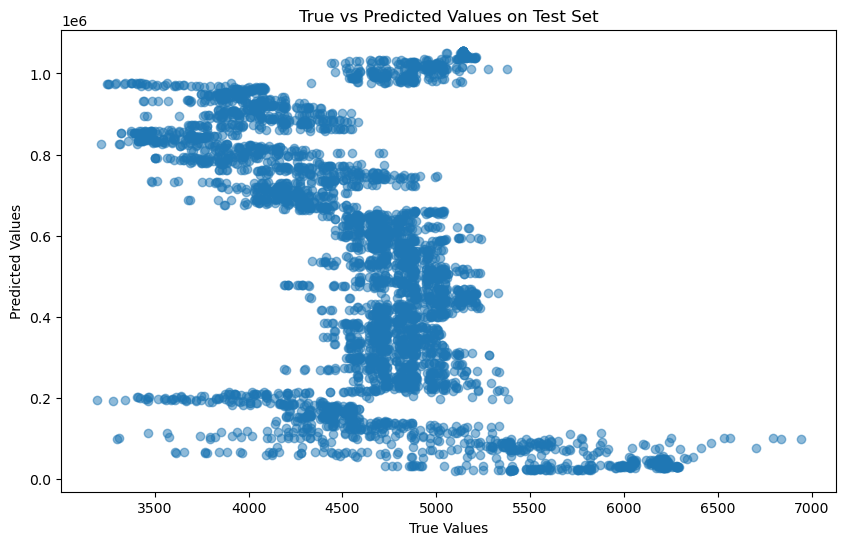

In [13]:
target_column = 'VP'

X_test = test_df_vp.drop(columns=['DEPT', target_column])
y_test = test_df_vp[target_column]

X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

model.eval()

with torch.no_grad():
    predictions = model(X_test_tensor)

mse = mean_squared_error(y_test_tensor.numpy(), predictions.numpy())
print(f'Test MSE: {mse}')

plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions.numpy(), alpha=0.5)
plt.title('True vs Predicted Values on Test Set')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.show()

Overall Trend: The dashed line in the plot presumably represents the line of perfect prediction where the true values are exactly equal to the predicted values. Most of the data points seem to cluster around this line, which suggests that the model has a decent level of accuracy.

Data Spread: The spread of the data points around the dashed line seems to be fairly consistent across the range of true values, with a slight fan-out at higher values. This indicates that the model's predictions are more variable at higher true values.

Bias: There does not seem to be a systematic bias where the model consistently overestimates or underestimates the true value. Instead, predictions are distributed both above and below the line of perfect prediction.

Outliers: There are some data points that are far from the line of perfect prediction, indicating instances where the model's predictions were quite inaccurate. However, these do not seem to be the majority.

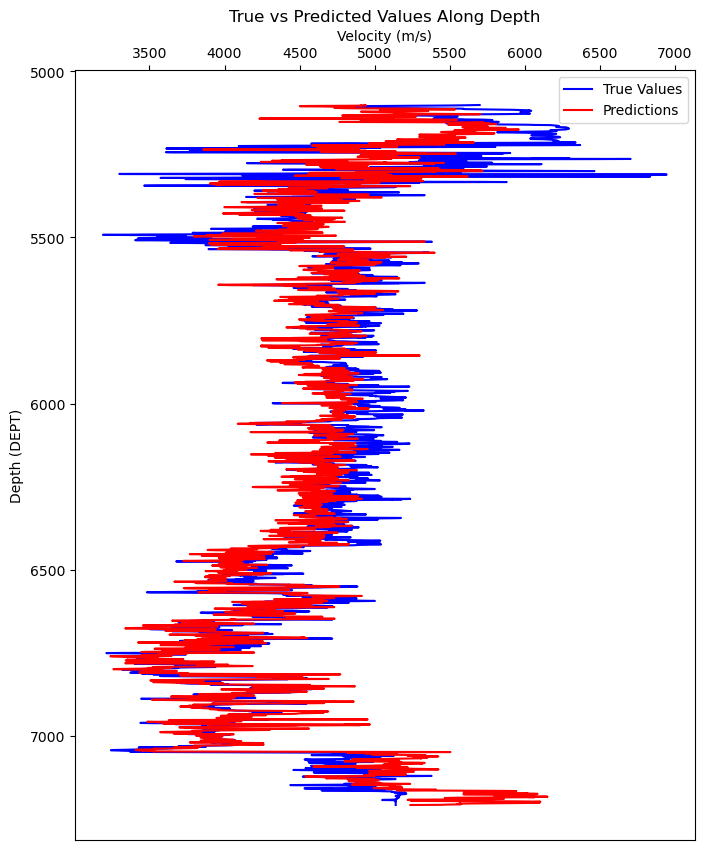

In [8]:
X_test = test_df_vp.drop(['DEPT', target_column], axis=1)
y_test = test_df_vp[target_column]
dept_test = test_df_vp['DEPT']

X_test_scaled = scaler.transform(X_test)

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
dept_test_tensor = torch.tensor(dept_test.values, dtype=torch.float32)

model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor).squeeze()

predictions_np = predictions.numpy()

plt.figure(figsize=(8, 10))
plt.gca().invert_yaxis()
plt.gca().xaxis.tick_top()
plt.gca().xaxis.set_label_position('top')
plt.plot(y_test, dept_test_tensor, label='True Values', color='blue')
plt.plot(predictions_np, dept_test_tensor, label='Predictions', color='red' , alpha=0.6)
plt.ylabel('Depth (DEPT)')
plt.xlabel('Velocity (m/s)')
plt.title('True vs Predicted Values Along Depth')
plt.legend()
plt.show()

## Training with XGBoost

In [97]:
cols = ['CALCITE','DOLOMITE','UWATER', 'CHLORITE', 'ILLITE', 
        'KAOLINITE','BOUND_WATER','K-FELDSPAR','QUARTZ', 'DEPT', 'VP']

train_df_vp_1 = train_df_vp[cols]
test_df_vp_1 = test_df_vp[cols]

In [42]:
target_column = 'VP'

X = train_df_vp_1.drop([target_column], axis=1)
y = train_df_vp_1[target_column]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [43]:
param_grid = {
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [50, 100, 200],
    'subsample': [0.7, 1],
    'colsample_bytree': [0.7, 1],
    'reg_alpha': [ 0.1]
}

xgb_model = XGBRegressor(objective='reg:squarederror')

grid_search = GridSearchCV(
    estimator=xgb_model, 
    param_grid=param_grid, 
    cv=5, 
    scoring='neg_mean_squared_error', 
    verbose=1)

grid_search.fit(X_train_scaled, y_train)

print(f"Best parameters found: {grid_search.best_params_}")

best_model = grid_search.best_estimator_
y_val_pred = best_model.predict(X_val_scaled)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters found: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 200, 'reg_alpha': 0.1, 'subsample': 1}


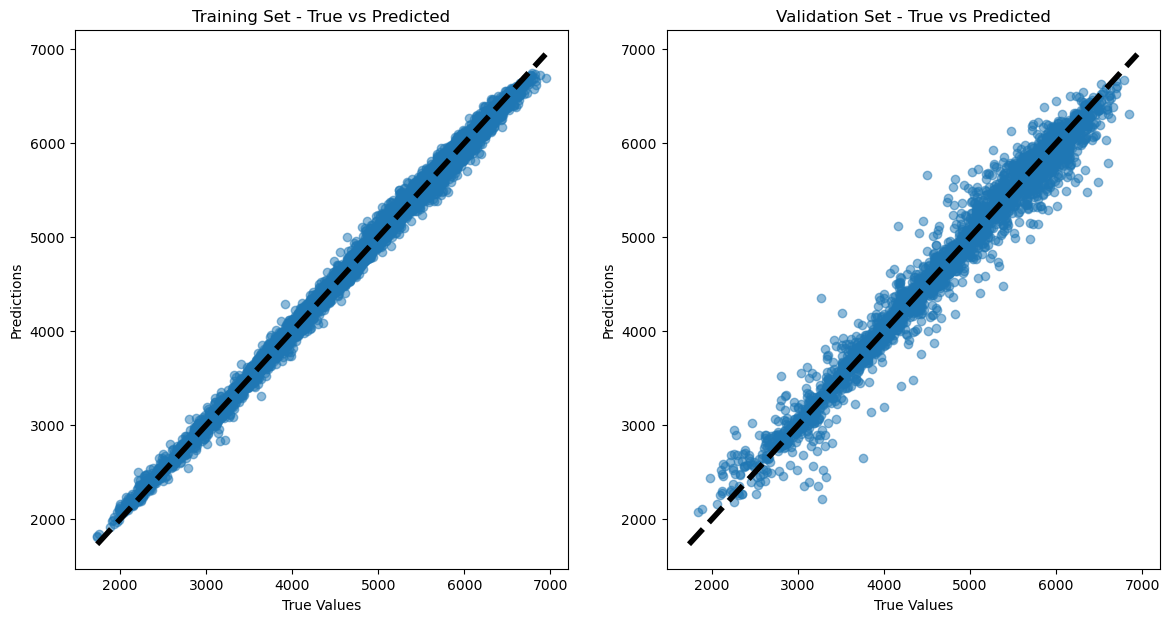

In [44]:
# Predict on the training and validation sets
y_train_pred = best_model.predict(X_train_scaled)
y_val_pred = best_model.predict(X_val_scaled)

# Plotting true vs predicted values for the training set
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
plt.title('Training Set - True vs Predicted')
plt.xlabel('True Values')
plt.ylabel('Predictions')

# Plotting true vs predicted values for the validation set
plt.subplot(1, 2, 2)
plt.scatter(y_val, y_val_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
plt.title('Validation Set - True vs Predicted')
plt.xlabel('True Values')
plt.ylabel('Predictions')

plt.show()

In [45]:
# Calculate error metrics for the training set
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Calculate error metrics for the validation set
val_rmse = mean_squared_error(y_val, y_val_pred, squared=False)
val_mae = mean_absolute_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)

print(f"Training RMSE: {train_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Training R-squared: {train_r2}")
print(f"Validation RMSE: {val_rmse}")
print(f"Validation MAE: {val_mae}")
print(f"Validation R-squared: {val_r2}")

Training RMSE: 56.193180953190684
Training MAE: 40.287812472742885
Training R-squared: 0.9968587204484982
Validation RMSE: 169.14753924812777
Validation MAE: 111.3277448153549
Validation R-squared: 0.9709735378250672


Text(0, 0.5, 'Residuals')

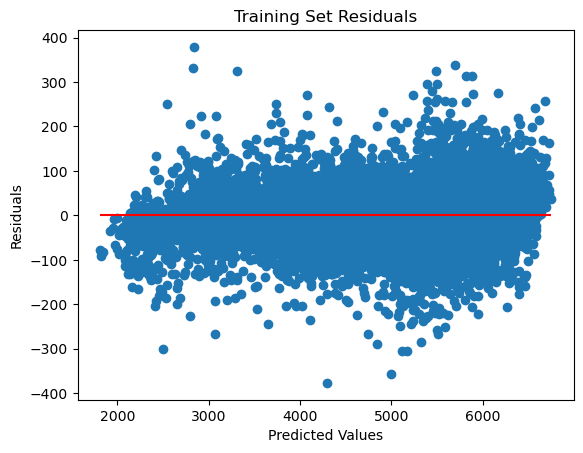

In [46]:
import matplotlib.pyplot as plt

# Plot residuals for training set
plt.scatter(y_train_pred, y_train - y_train_pred)
plt.hlines(0, min(y_train_pred), max(y_train_pred), color='red')
plt.title('Training Set Residuals')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

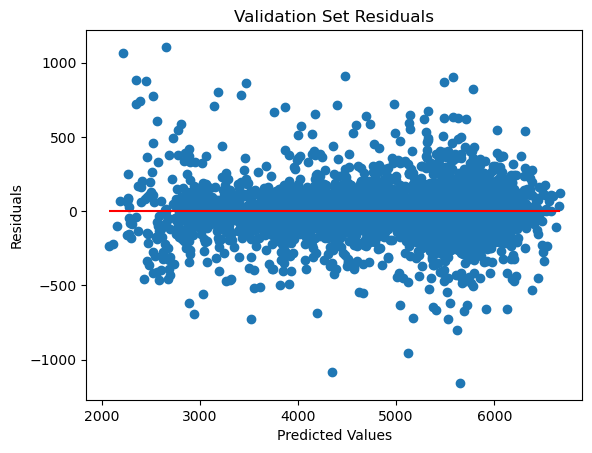

In [47]:
# Plot residuals for validation set

plt.scatter(y_val_pred, y_val - y_val_pred)
plt.hlines(0, min(y_val_pred), max(y_val_pred), color='red')
plt.title('Validation Set Residuals')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

plt.show()

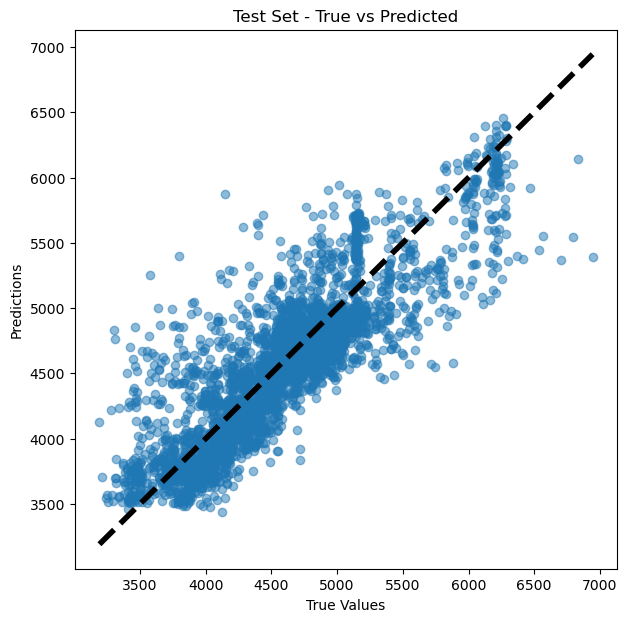

In [49]:
X_test = test_df_vp_1.drop([ 'VP'], axis=1)
y_test = test_df_vp_1['VP']

X_test_scaled = scaler.transform(X_test)

y_test_pred = best_model.predict(X_test_scaled)

plt.figure(figsize=(7, 7))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.title('Test Set - True vs Predicted')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

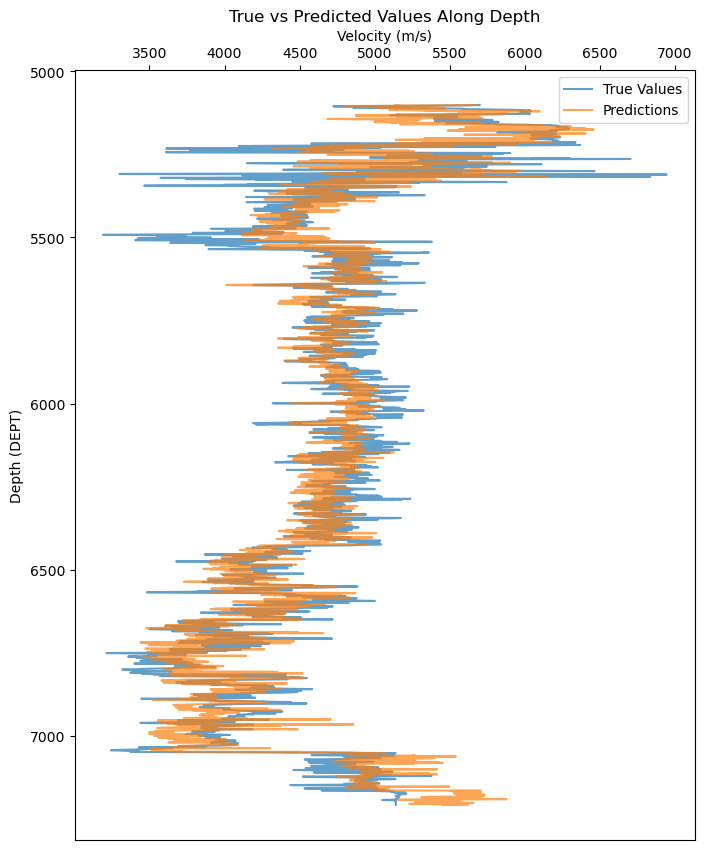

In [51]:
X_test = test_df_vp_1.drop(['VP'], axis=1)
y_test = test_df_vp_1['VP']
depth = test_df_vp['DEPT']

X_test_scaled = scaler.transform(X_test)
y_test_pred = best_model.predict(X_test_scaled)

plt.figure(figsize=(8, 10))
plt.gca().invert_yaxis()
plt.gca().xaxis.tick_top()
plt.gca().xaxis.set_label_position('top')
plt.plot(y_test, depth, label='True Values', alpha=0.7)
plt.plot(y_test_pred, depth, label='Predictions', alpha=0.7)
plt.ylabel('Depth (DEPT)')
plt.xlabel('Velocity (m/s)')
plt.title('True vs Predicted Values Along Depth')
plt.legend()
plt.show()

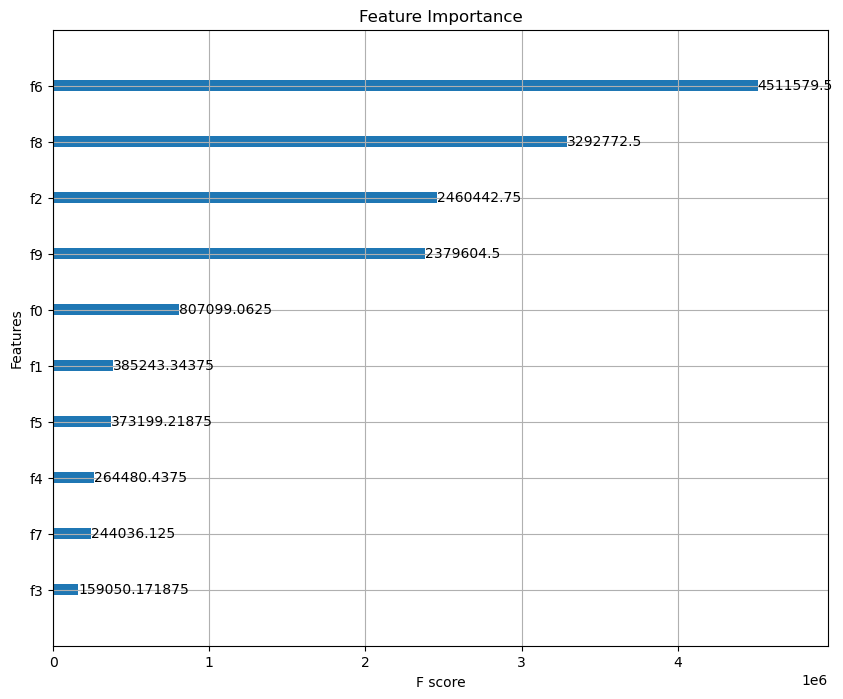

In [54]:
fig, ax = plt.subplots(figsize=(10, 8))
xgb.plot_importance(best_model, ax=ax, importance_type='gain', show_values=True)
plt.title('Feature Importance')
plt.show()

## Training with XGBoost (Including V-R Boundaries in Training Set)

In [103]:
# Split the features and target
X = train_df_vp_1.drop('VP', axis=1)
y = train_df_vp_1['VP']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

# Initialize XGBoost regressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Fit the model
xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=10, verbose=True)

# Make predictions on the validation set
y_train_pred = xgb_model.predict(X_train)
y_val_pred = xgb_model.predict(X_val)

# Calculate MSE for the validation set
mse = mean_squared_error(y_val, y_val_pred, squared=False)
print(f'Mean Squared Error on the validation set: {mse}')

[0]	validation_0-rmse:742.45745
[1]	validation_0-rmse:566.28869
[2]	validation_0-rmse:445.44642
[3]	validation_0-rmse:365.18283
[4]	validation_0-rmse:315.63980
[5]	validation_0-rmse:286.31050
[6]	validation_0-rmse:263.64305
[7]	validation_0-rmse:251.67244
[8]	validation_0-rmse:243.34711
[9]	validation_0-rmse:235.85055
[10]	validation_0-rmse:231.08647
[11]	validation_0-rmse:227.50834
[12]	validation_0-rmse:224.28179
[13]	validation_0-rmse:218.49068
[14]	validation_0-rmse:217.37260
[15]	validation_0-rmse:216.78838
[16]	validation_0-rmse:215.38148
[17]	validation_0-rmse:214.49428
[18]	validation_0-rmse:211.93445
[19]	validation_0-rmse:211.68171
[20]	validation_0-rmse:210.93358
[21]	validation_0-rmse:210.50411
[22]	validation_0-rmse:209.73784
[23]	validation_0-rmse:208.93266
[24]	validation_0-rmse:208.26699
[25]	validation_0-rmse:207.48029
[26]	validation_0-rmse:207.58103
[27]	validation_0-rmse:207.02222
[28]	validation_0-rmse:206.66022
[29]	validation_0-rmse:206.14220
[30]	validation_0-rm

/Users/anshankul/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[48]	validation_0-rmse:201.25548
[49]	validation_0-rmse:200.92428
[50]	validation_0-rmse:200.66626
[51]	validation_0-rmse:200.43408
[52]	validation_0-rmse:199.95852
[53]	validation_0-rmse:199.75013
[54]	validation_0-rmse:199.79736
[55]	validation_0-rmse:199.69744
[56]	validation_0-rmse:199.22090
[57]	validation_0-rmse:199.02524
[58]	validation_0-rmse:198.95546
[59]	validation_0-rmse:198.88620
[60]	validation_0-rmse:198.73698
[61]	validation_0-rmse:198.66770
[62]	validation_0-rmse:198.51518
[63]	validation_0-rmse:198.27738
[64]	validation_0-rmse:198.01413
[65]	validation_0-rmse:197.85209
[66]	validation_0-rmse:197.32811
[67]	validation_0-rmse:197.04820
[68]	validation_0-rmse:197.08876
[69]	validation_0-rmse:196.97023
[70]	validation_0-rmse:196.61799
[71]	validation_0-rmse:196.43421
[72]	validation_0-rmse:196.19825
[73]	validation_0-rmse:196.12525
[74]	validation_0-rmse:196.04941
[75]	validation_0-rmse:195.83908
[76]	validation_0-rmse:195.64187
[77]	validation_0-rmse:195.50769
[78]	valid

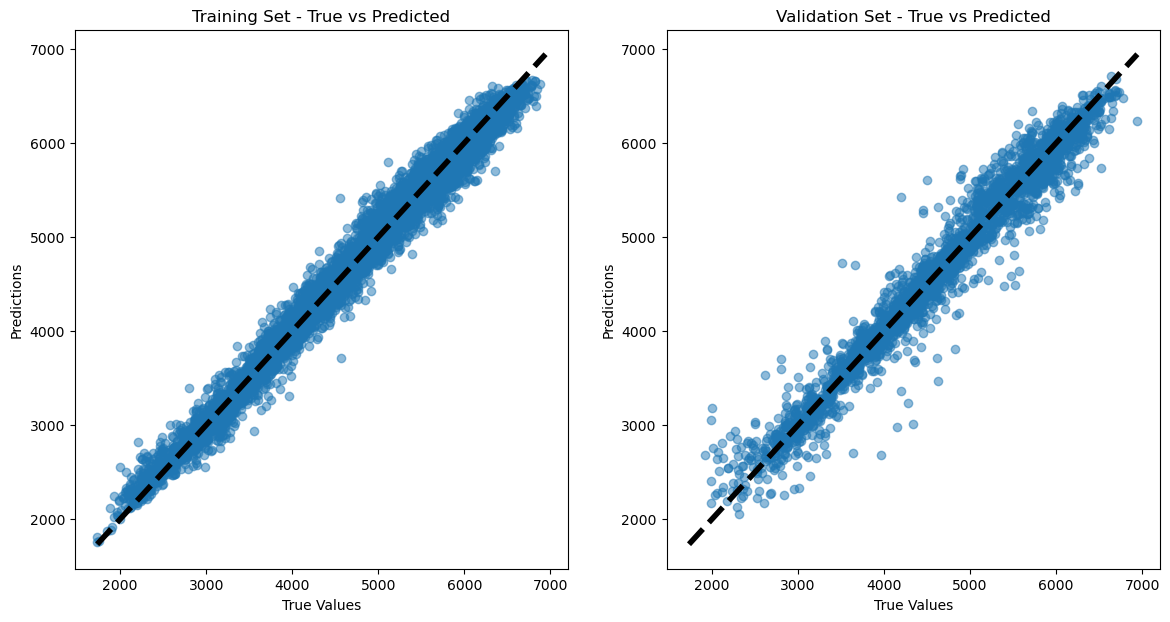

In [104]:
# Predict on the training and validation sets
y_train_pred = xgb_model.predict(X_train)
y_val_pred = xgb_model.predict(X_val)

# Plotting true vs predicted values for the training set
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
plt.title('Training Set - True vs Predicted')
plt.xlabel('True Values')
plt.ylabel('Predictions')

# Plotting true vs predicted values for the validation set
plt.subplot(1, 2, 2)
plt.scatter(y_val, y_val_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
plt.title('Validation Set - True vs Predicted')
plt.xlabel('True Values')
plt.ylabel('Predictions')

plt.show()

In [105]:
# Calculate error metrics for the training set
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Calculate error metrics for the validation set
val_rmse = mean_squared_error(y_val, y_val_pred, squared=False)
val_mae = mean_absolute_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)

print(f"Training RMSE: {train_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Training R-squared: {train_r2}")
print(f"Validation RMSE: {val_rmse}")
print(f"Validation MAE: {val_mae}")
print(f"Validation R-squared: {val_r2}")

Training RMSE: 112.83344907541334
Training MAE: 81.73712729897224
Training R-squared: 0.9872644551559786
Validation RMSE: 192.99117913678933
Validation MAE: 127.56241920405476
Validation R-squared: 0.9629841664320702


In [106]:
X_train.columns


Index(['CALCITE', 'DOLOMITE', 'UWATER', 'CHLORITE', 'ILLITE', 'KAOLINITE',
       'BOUND_WATER', 'K-FELDSPAR', 'QUARTZ', 'DEPT'],
      dtype='object')

In [107]:
X_test.columns

Index(['CALCITE', 'DOLOMITE', 'UWATER', 'CHLORITE', 'ILLITE', 'KAOLINITE',
       'BOUND_WATER', 'K-FELDSPAR', 'QUARTZ', 'DEPT'],
      dtype='object')

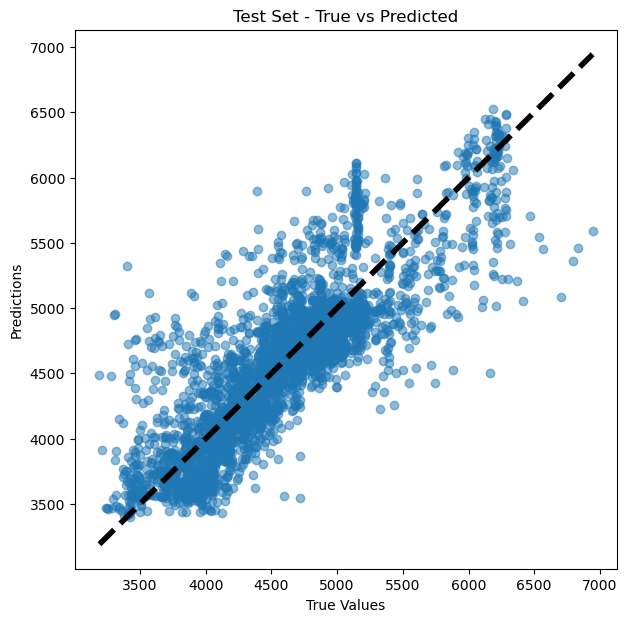

In [109]:
X_test = test_df_vp_1.drop([ 'VP'], axis=1)
y_test = test_df_vp_1['VP']

#X_test_scaled = scaler.transform(X_test)
y_test_pred = xgb_model.predict(X_test)

plt.figure(figsize=(7, 7))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.title('Test Set - True vs Predicted')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

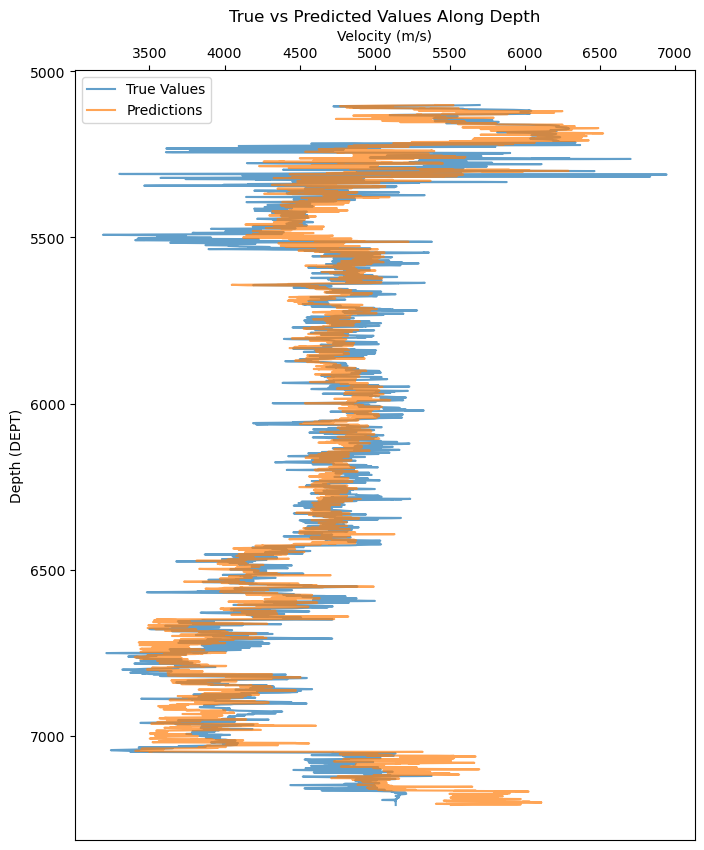

In [115]:
# TESTING DATA PLOT
import matplotlib.pyplot as plt

X_test = test_df_vp_1.drop(['VP'], axis=1)
y_test = test_df_vp_1['VP']
depth = test_df_vp_1['DEPT']

#X_test_scaled = scaler.transform(X_test)
y_test_pred = xgb_model.predict(X_test)

plt.figure(figsize=(8, 10))
plt.gca().invert_yaxis()
plt.gca().xaxis.tick_top()
plt.gca().xaxis.set_label_position('top')
plt.plot(y_test, depth, label='True Values', alpha=0.7)
plt.plot(y_test_pred, depth, label='Predictions', alpha=0.7)
plt.ylabel('Depth (DEPT)')
plt.xlabel('Velocity (m/s)')
plt.title('True vs Predicted Values Along Depth')
plt.legend()
plt.show()

## Final XGBoost

### 1. Training for Vp 

In [8]:
target_column = 'VP'

X = train_df_vp.drop([target_column], axis=1)
y = train_df_vp[target_column]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [4]:
param_grid = {
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [50, 100, 200],
    'subsample': [0.7, 1],
    'colsample_bytree': [0.7, 1],
    'reg_alpha': [ 0.1]
}

xgb_model = XGBRegressor(objective='reg:squarederror')

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train_scaled, y_train)

print(f"Best parameters found: {grid_search.best_params_}")

best_model = grid_search.best_estimator_
y_val_pred = best_model.predict(X_val_scaled)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


KeyboardInterrupt: 

In [152]:
filename = 'best_xgb_model.joblib'
joblib.dump(best_model, filename)

['best_xgb_model.joblib']

In [10]:
filename = 'best_xgb_model.joblib'
best_model = joblib.load(filename)

In [3]:
best_model

NameError: name 'best_model' is not defined

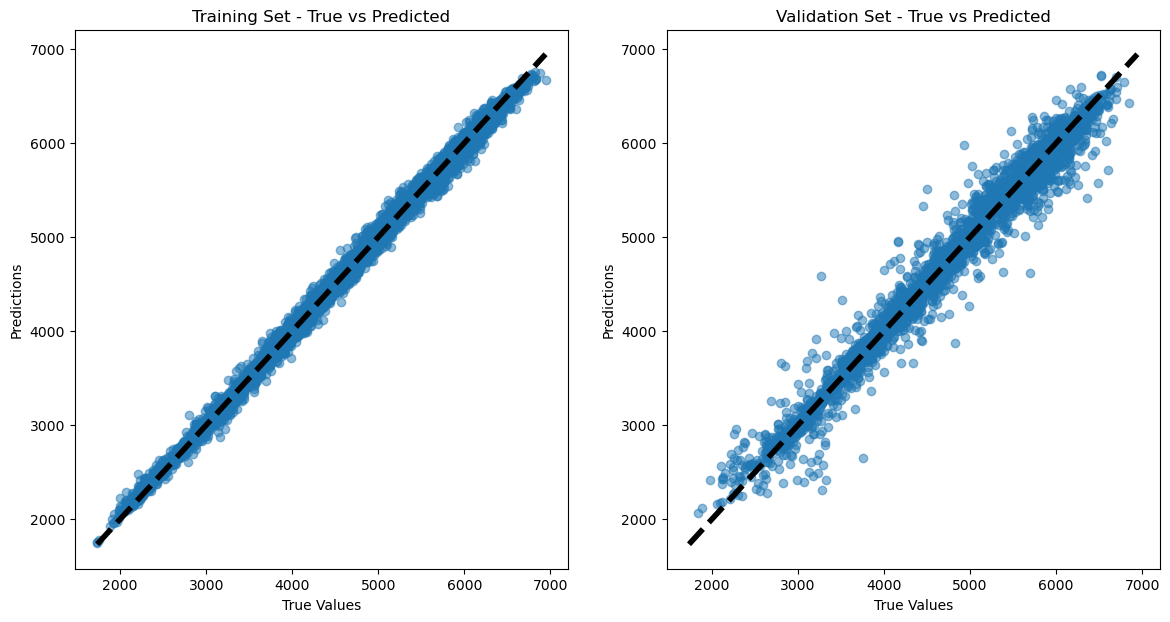

In [12]:
# Predict on the training and validation sets
y_train_pred = best_model.predict(X_train_scaled)
y_val_pred = best_model.predict(X_val_scaled)

# Plotting true vs predicted values for the training set
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
plt.title('Training Set - True vs Predicted')
plt.xlabel('True Values')
plt.ylabel('Predictions')

# Plotting true vs predicted values for the validation set
plt.subplot(1, 2, 2)
plt.scatter(y_val, y_val_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
plt.title('Validation Set - True vs Predicted')
plt.xlabel('True Values')
plt.ylabel('Predictions')

plt.show()

In [13]:
# Calculate error metrics for the training set
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Calculate error metrics for the validation set
val_rmse = mean_squared_error(y_val, y_val_pred, squared=False)
val_mae = mean_absolute_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)

print(f"Training RMSE: {train_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Training R-squared: {train_r2}")
print(f"Validation RMSE: {val_rmse}")
print(f"Validation MAE: {val_mae}")
print(f"Validation R-squared: {val_r2}")

Training RMSE: 54.30734562404746
Training MAE: 39.67940112223634
Training R-squared: 0.9970660243464149
Validation RMSE: 171.14808366026782
Validation MAE: 112.10364082883248
Validation R-squared: 0.9702828730640825


Text(0, 0.5, 'Residuals')

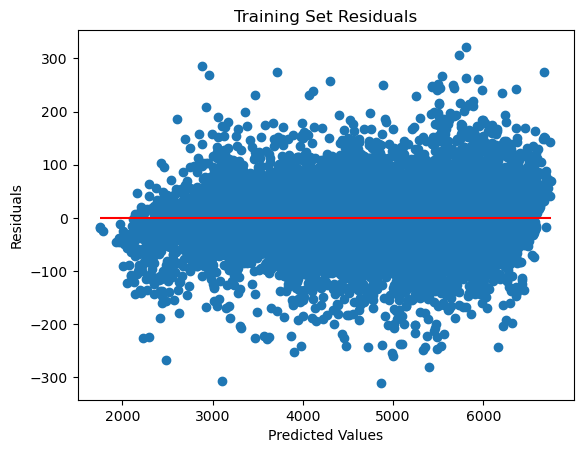

In [14]:
plt.scatter(y_train_pred, y_train - y_train_pred)
plt.hlines(0, min(y_train_pred), max(y_train_pred), color='red')
plt.title('Training Set Residuals')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

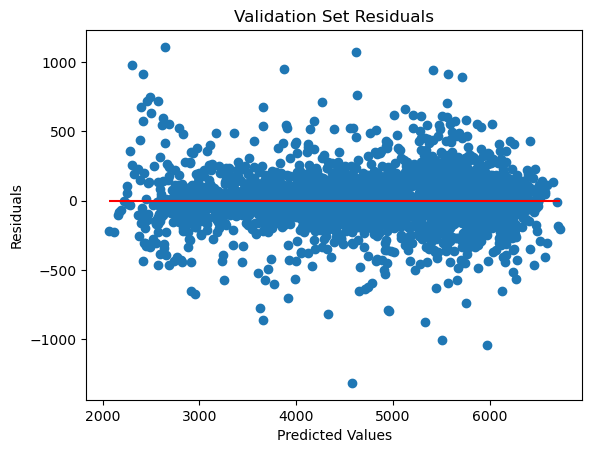

In [15]:
# Plot residuals for validation set
plt.scatter(y_val_pred, y_val - y_val_pred)
plt.hlines(0, min(y_val_pred), max(y_val_pred), color='red')
plt.title('Validation Set Residuals')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

plt.show()

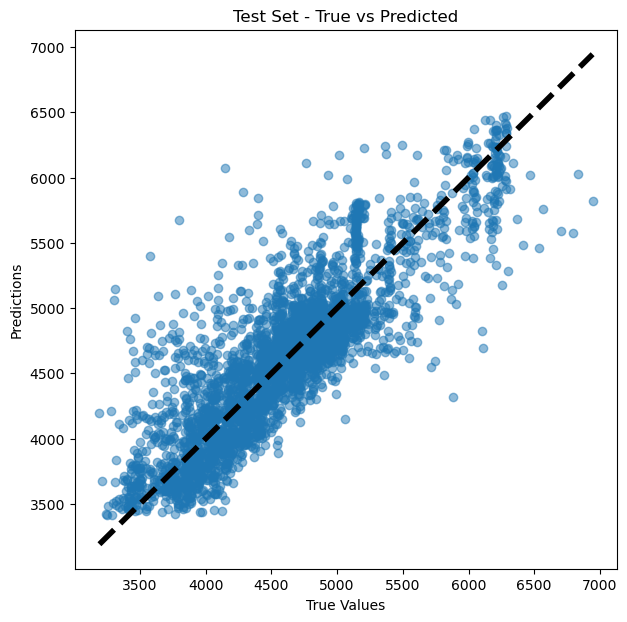

In [18]:
X_test = test_df_vp.drop([ 'VP', 'RHOZ', 'VOIGT_VP', 'REUSS_VP', 'VRH_VP'], axis=1)
y_test = test_df_vp['VP']

X_test_scaled = scaler.transform(X_test)

y_test_pred = best_model.predict(X_test_scaled)

plt.figure(figsize=(7, 7))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.title('Test Set - True vs Predicted')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

In [19]:
# FORMATTING GRAPHS
def feet_to_meters(feet):
    return feet * 0.3048

test_df_vp['DEPT'] = test_df_vp['DEPT'].apply(feet_to_meters)

In [20]:
test_df_vp

,BOUND_WATER,CALCITE,CHLORITE,DOLOMITE,ILLITE,K-FELDSPAR,KAOLINITE,QUARTZ,UWATER,DEPT,...,Voigt_Bulk,Reuss_Bulk,Voigt_Shear,Reuss_Shear,K_VRH,G_VRH,VP,VOIGT_VP,REUSS_VP,VRH_VP
0,0.00026,0.08100,0.00000,0.47844,0.00000,0.23040,0.00381,0.10848,0.05685,1554.7848,...,64.409873,22.898393,32.356260,0.001751,43.654133,16.179005,5699.424897,6403.244580,2954.720357,4986.577661
1,0.00008,0.06900,0.00000,0.47355,0.00000,0.23773,0.00114,0.11768,0.05759,1554.9372,...,63.636714,23.594883,32.263222,0.001734,43.615799,16.132478,5612.334615,6384.419770,3003.048539,4988.943592
2,0.00003,0.04209,0.00000,0.48604,0.00000,0.24202,0.00041,0.12550,0.05397,1555.0896,...,63.196373,24.792859,32.371559,0.001852,43.994616,16.186706,5580.766861,6367.070757,3074.245872,4999.528863
3,0.00036,0.05095,0.00000,0.43499,0.00000,0.25269,0.00529,0.15076,0.04891,1555.2420,...,60.363835,23.819622,31.636151,0.002029,42.091729,15.819090,5496.963955,6265.390794,3019.828207,4918.052674
4,0.00088,0.08433,0.00000,0.29721,0.00000,0.27180,0.01301,0.23370,0.03773,1555.3944,...,53.625630,22.718279,30.451028,0.002590,38.171954,15.226809,5337.044517,6033.921752,2963.007179,4753.294818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4212,0.00940,0.00000,0.02083,0.12972,0.04289,0.16409,0.02395,0.51980,0.00001,2196.6936,...,37.848610,12.118974,31.292689,0.010617,24.983792,15.651653,5140.448244,5425.020946,2118.396164,4118.158239
4213,0.00931,0.00000,0.02140,0.19529,0.04213,0.14979,0.02296,0.47591,0.00001,2196.8460,...,41.909055,12.374546,32.096027,0.010720,27.141800,16.053373,5140.448244,5603.063400,2142.838779,4241.820217
4214,0.00981,0.00000,0.02457,0.21701,0.04374,0.14476,0.02161,0.46449,0.00399,2196.9984,...,43.374119,11.775766,32.500299,0.007242,27.574942,16.253771,5140.448244,5673.588374,2091.708537,4275.795227
4215,0.00992,0.00002,0.02629,0.22285,0.04463,0.11656,0.01845,0.49333,0.00600,2197.1508,...,43.943290,11.681370,33.608930,0.006278,27.812330,16.807604,5140.448244,5756.917237,2089.274645,4330.540648


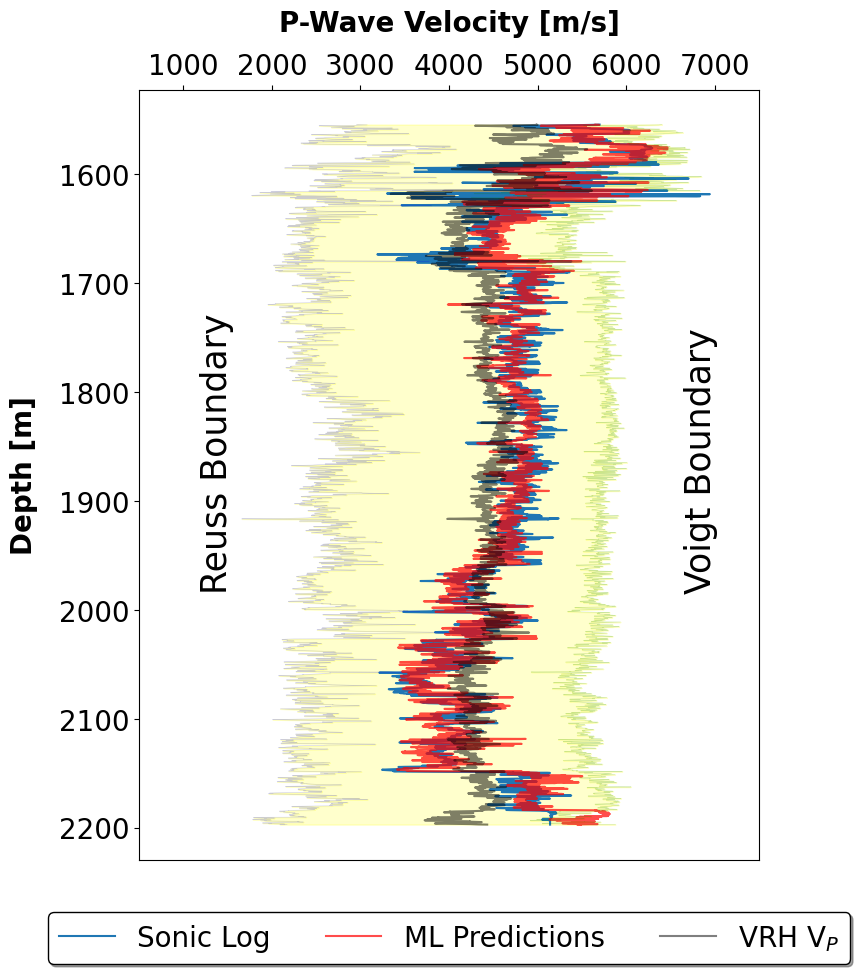

In [34]:
# Plot For PWave velocity
depth = test_df_vp['DEPT']
voigt_boundary = test_df_vp['VOIGT_VP']
reuss_boundary = test_df_vp['REUSS_VP']
vp_vrh = test_df_vp['VRH_VP']

# Plotting the data, with vertical annotations for Voigt and Reuss boundaries and increased font size
plt.figure(figsize=(8, 10))
plt.gca().invert_yaxis()
plt.gca().xaxis.tick_top()
plt.gca().xaxis.set_label_position('top')

plt.plot(y_test, depth, label='Sonic Log', alpha=1)
plt.plot(y_test_pred, depth, label='ML Predictions', alpha=0.7, color='red')
plt.plot(vp_vrh, depth, label='VRH V$_{P}$', alpha=0.5, color='black')
plt.plot(voigt_boundary, depth, alpha=0.2, linewidth=0.4, color='Green')
plt.plot(reuss_boundary, depth, alpha=0.2, linewidth=0.4, color='Blue')

plt.fill_betweenx(depth, voigt_boundary, reuss_boundary, where=(voigt_boundary >= reuss_boundary), 
                  interpolate=True, color='yellow', alpha=0.2)

#plt.legend(loc='upper center', bbox_to_anchor=(0.5, 0), shadow=True, ncol=2, framealpha=1.0, edgecolor='black', facecolor='white', frameon=True)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=3, framealpha=1.0, edgecolor='black', facecolor='white', frameon=True)


plt.ylabel('Depth [m]', fontweight='bold', labelpad=15)
plt.xlabel('P-Wave Velocity [m/s]', fontweight='bold', labelpad=15)
plt.rcParams['font.size'] = 20
plt.xlim(500, 7500)
# plt.rcParams['font.family'] = 'arial'

voigt_annotation_point = (np.max(voigt_boundary), np.mean(depth))
reuss_annotation_point = (np.max(reuss_boundary), np.mean(depth))

plt.annotate('Voigt Boundary', xy=voigt_annotation_point, xytext=(0, -80), textcoords='offset points',
             rotation='vertical', ha='center', fontsize=25, color='Black')

plt.annotate('Reuss Boundary', xy=reuss_annotation_point, xytext=(-190, -80), textcoords='offset points',
             rotation='vertical', ha='center', fontsize=25, color='Black')

plt.show()

### 2. Training for Vs

In [35]:
train_df_vs.head()

,BOUND_WATER,CALCITE,CHLORITE,DOLOMITE,ILLITE,K-FELDSPAR,KAOLINITE,QUARTZ,UWATER,DEPT,Voigt_Bulk,Reuss_Bulk,Voigt_Shear,Reuss_Shear,K_VRH,G_VRH,VS
0,0.00139,0.92588,0.0,0.0,0.00081,0.04413,0.01871,0.00906,0.00001,4361.25,73.130039,36.863518,30.716078,0.071195,54.996778,15.393636,3595.064147
1,0.00291,0.91290,0.0,0.0,0.01286,0.04058,0.01871,0.01203,0.00001,4361.75,72.131359,28.036393,30.395018,0.034183,50.083876,15.214601,3574.159111
2,0.00468,0.89792,0.0,0.0,0.02690,0.03663,0.01871,0.01373,0.00144,4362.25,70.923770,21.631896,29.950865,0.016323,46.277833,14.983594,3548.413197
3,0.00407,0.88793,0.0,0.0,0.02208,0.03811,0.01871,0.01604,0.01306,4362.75,70.314500,20.837212,29.748278,0.005836,45.575856,14.877057,3545.193129
4,0.00134,0.88843,0.0,0.0,0.00042,0.04504,0.01871,0.01929,0.02676,4363.25,70.724669,25.762189,29.980905,0.003558,48.243429,14.992231,3560.947343


In [36]:
target_column = 'VS'

X = train_df_vs.drop([target_column], axis=1)
y = train_df_vs[target_column]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [273]:
param_grid = {
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [50, 100, 200],
    'subsample': [0.7, 1],
    'colsample_bytree': [0.7, 1],
    'reg_alpha': [ 0.1]
}

xgb_model = XGBRegressor(objective='reg:squarederror')

grid_search = GridSearchCV(estimator=xgb_model, 
                           param_grid=param_grid, 
                           cv=5, 
                           scoring='neg_mean_squared_error', 
                           verbose=1)
grid_search.fit(X_train_scaled, y_train)

print(f"Best parameters found: {grid_search.best_params_}")

best_model = grid_search.best_estimator_
y_val_pred = best_model.predict(X_val_scaled)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters found: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 200, 'reg_alpha': 0.1, 'subsample': 1}


In [274]:
filename = 'best1_xgb_model.joblib'
joblib.dump(best_model, filename)

['best1_xgb_model.joblib']

In [37]:
filename = 'best1_xgb_model.joblib'
best_model = joblib.load(filename)

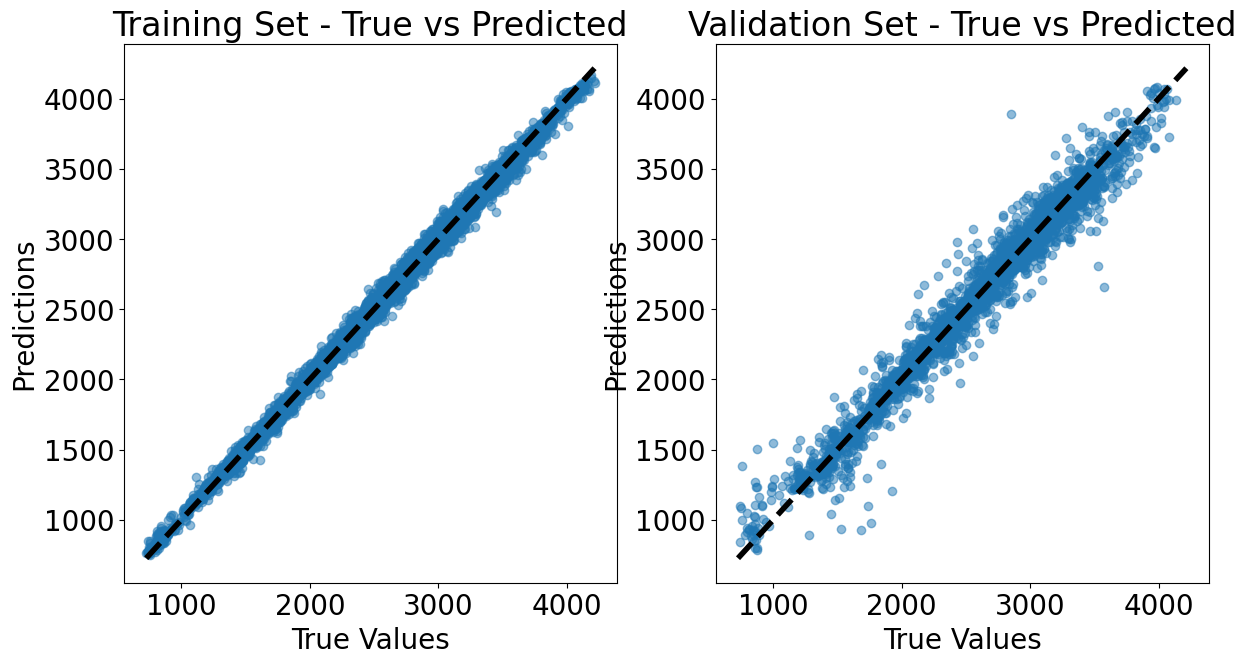

In [38]:
# Predict on the training and validation sets
y_train_pred = best_model.predict(X_train_scaled)
y_val_pred = best_model.predict(X_val_scaled)

# Plotting true vs predicted values for the training set
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
plt.title('Training Set - True vs Predicted')
plt.xlabel('True Values')
plt.ylabel('Predictions')

# Plotting true vs predicted values for the validation set
plt.subplot(1, 2, 2)
plt.scatter(y_val, y_val_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
plt.title('Validation Set - True vs Predicted')
plt.xlabel('True Values')
plt.ylabel('Predictions')

plt.show()

In [39]:
# Calculate error metrics for the training set
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Calculate error metrics for the validation set
val_rmse = mean_squared_error(y_val, y_val_pred, squared=False)
val_mae = mean_absolute_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)

print(f"Training RMSE: {train_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Training R-squared: {train_r2}")
print(f"Validation RMSE: {val_rmse}")
print(f"Validation MAE: {val_mae}")
print(f"Validation R-squared: {val_r2}")

Training RMSE: 35.80691039958487
Training MAE: 26.186850529223804
Training R-squared: 0.9969858347405326
Validation RMSE: 110.55924332182823
Validation MAE: 73.96297183654299
Validation R-squared: 0.9707370016141141


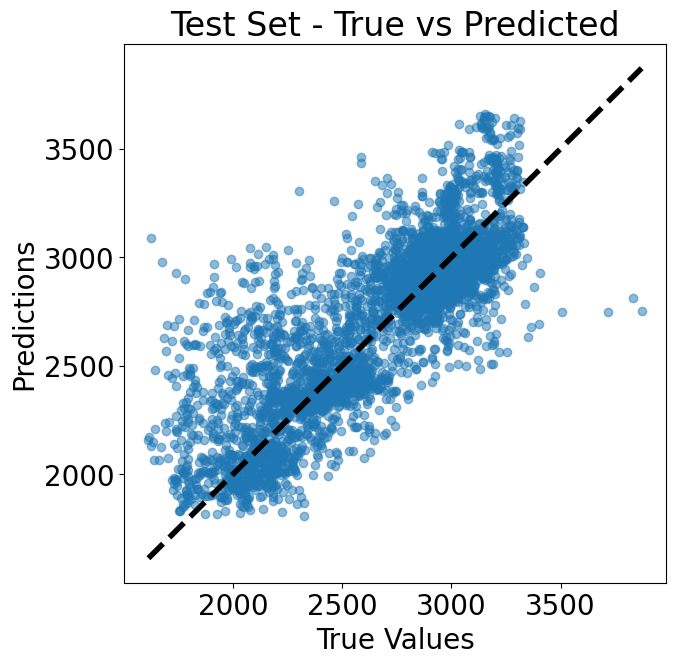

In [40]:
X_test = test_df_vs.drop([ 'VS', 'RHOZ', 'VOIGT_VS', 'REUSS_VS', 'VRH_VS'], axis=1)
y_test = test_df_vs['VS']

X_test_scaled = scaler.transform(X_test)

y_test_pred = best_model.predict(X_test_scaled)

plt.figure(figsize=(7, 7))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.title('Test Set - True vs Predicted')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

In [296]:
test_df_vs

,BOUND_WATER,CALCITE,CHLORITE,DOLOMITE,ILLITE,K-FELDSPAR,KAOLINITE,QUARTZ,UWATER,DEPT,...,Voigt_Bulk,Reuss_Bulk,Voigt_Shear,Reuss_Shear,K_VRH,G_VRH,VS,VOIGT_VS,REUSS_VS,VRH_VS
0,0.00026,0.08100,0.00000,0.47844,0.00000,0.23040,0.00381,0.10848,0.05685,1554.7848,...,64.409873,22.898393,32.356260,0.001751,43.654133,16.179005,2946.238968,3512.132604,25.835856,2483.519974
1,0.00008,0.06900,0.00000,0.47355,0.00000,0.23773,0.00114,0.11768,0.05759,1554.9372,...,63.636714,23.594883,32.263222,0.001734,43.615799,16.132478,2959.233644,3511.446274,25.742169,2483.034192
2,0.00003,0.04209,0.00000,0.48604,0.00000,0.24202,0.00041,0.12550,0.05397,1555.0896,...,63.196373,24.792859,32.371559,0.001852,43.994616,16.186706,2954.210608,3512.654880,26.567101,2483.893125
3,0.00036,0.05095,0.00000,0.43499,0.00000,0.25269,0.00529,0.15076,0.04891,1555.2420,...,60.363835,23.819622,31.636151,0.002029,42.091729,15.819090,2923.682674,3480.021737,27.872973,2460.825897
4,0.00088,0.08433,0.00000,0.29721,0.00000,0.27180,0.01301,0.23370,0.03773,1555.3944,...,53.625630,22.718279,30.451028,0.002590,38.171954,15.226809,2865.826839,3430.148870,31.632862,2425.584662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4212,0.00940,0.00000,0.02083,0.12972,0.04289,0.16409,0.02395,0.51980,0.00001,2196.6936,...,37.848610,12.118974,31.292689,0.010617,24.983792,15.651653,3009.357443,3402.061742,62.664614,2406.028984
4213,0.00931,0.00000,0.02140,0.19529,0.04213,0.14979,0.02296,0.47591,0.00001,2196.8460,...,41.909055,12.374546,32.096027,0.010720,27.141800,16.053373,3009.357443,3449.052747,63.032397,2439.255823
4214,0.00981,0.00000,0.02457,0.21701,0.04374,0.14476,0.02161,0.46449,0.00399,2196.9984,...,43.374119,11.775766,32.500299,0.007242,27.574942,16.253771,3009.357443,3473.539902,51.849988,2456.437245
4215,0.00992,0.00002,0.02629,0.22285,0.04463,0.11656,0.01845,0.49333,0.00600,2197.1508,...,43.943290,11.681370,33.608930,0.006278,27.812330,16.807604,3009.357443,3542.586248,48.417446,2505.220706


In [41]:
def feet_to_meters(feet):
    return feet * 0.3048

test_df_vs['DEPT'] = test_df_vs['DEPT'].apply(feet_to_meters)

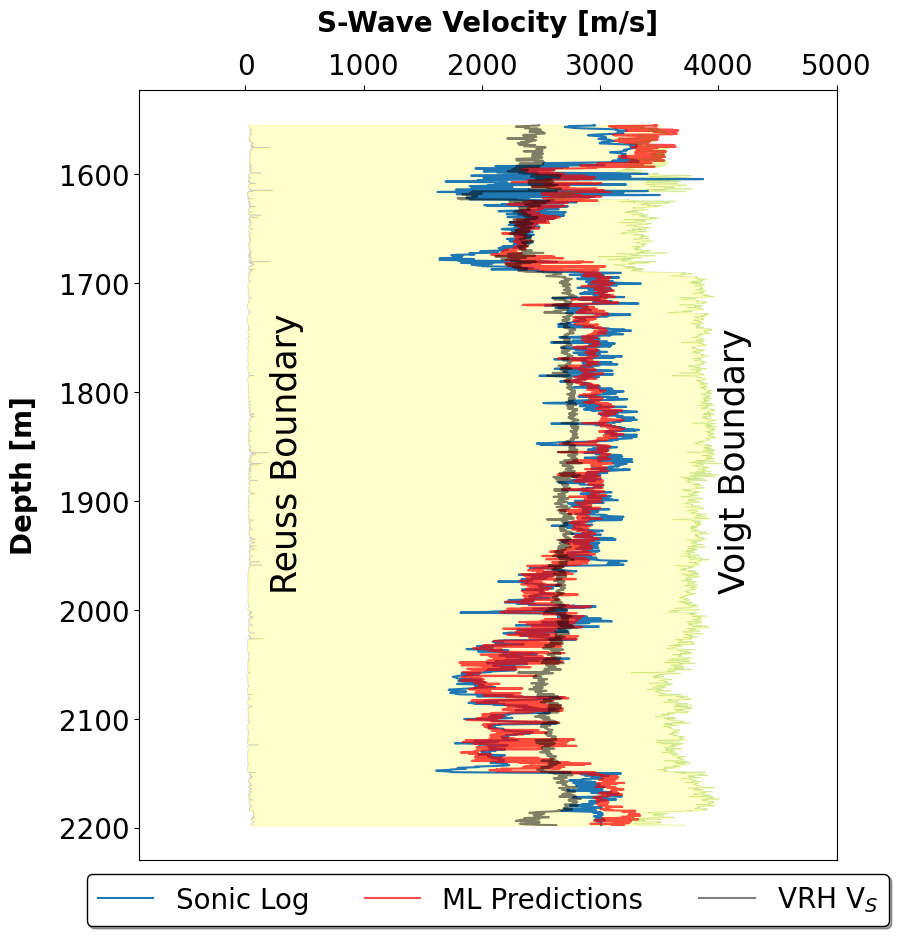

In [42]:
depth = test_df_vs['DEPT']
voigt_boundary = test_df_vs['VOIGT_VS']
reuss_boundary = test_df_vs['REUSS_VS']
vs_vrh = test_df_vs['VRH_VS']

plt.figure(figsize=(9, 10))
plt.gca().invert_yaxis()
plt.gca().xaxis.tick_top()
plt.gca().xaxis.set_label_position('top')

plt.plot(y_test, depth, label='Sonic Log', alpha=1)
plt.plot(y_test_pred, depth, label='ML Predictions', alpha=0.7, color='red')
plt.plot(vs_vrh, depth, label='VRH V$_{S}$', alpha=0.5, color='black')
plt.plot(voigt_boundary, depth, alpha=0.2, linewidth=0.4, color='Green')
plt.plot(reuss_boundary, depth, alpha=0.2, linewidth=0.4, color='Blue')

plt.xlim(-900, 5000)

plt.fill_betweenx(depth, voigt_boundary, reuss_boundary, where=(voigt_boundary >= reuss_boundary), 
                  interpolate=True, color='yellow', alpha=0.2)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 0), shadow=True, ncol=3, 
           framealpha=1.0, edgecolor='black', facecolor='white', frameon=True)

plt.ylabel('Depth [m]', fontweight='bold', labelpad=15)
plt.xlabel('S-Wave Velocity [m/s]', fontweight='bold', labelpad=15)
plt.rcParams['font.size'] = 20
# plt.rcParams['font.family'] = 'arial'

voigt_annotation_point = (np.max(voigt_boundary), np.mean(depth))
reuss_annotation_point = (np.max(reuss_boundary), np.mean(depth))

plt.annotate('Voigt Boundary', xy=voigt_annotation_point, xytext=(10, -80), textcoords='offset points',
             rotation='vertical', ha='center', fontsize=25, color='Black')

plt.annotate('Reuss Boundary', xy=reuss_annotation_point, xytext=(10, -80), textcoords='offset points',
             rotation='vertical', ha='center', fontsize=25, color='Black')

plt.show()